# How to use Autopycoin

This notebook is a quick start for autopycoin. We will demonstrate its efficiency through a toy example.

## Import

As our package is based on tensorflow we need to import it.

In [1]:
import tensorflow as tf

Let's create our data thanks to `random_ts` which generate a fake time serie based on a trend and seasonality components.

Text(0.5, 1.0, 'Generated data')

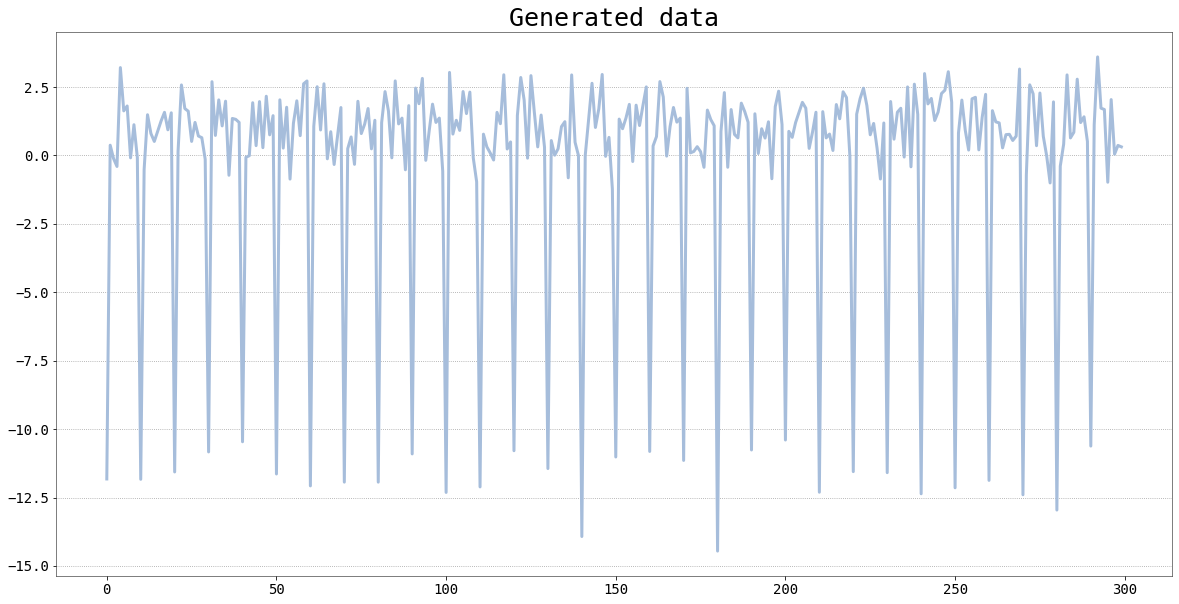

In [24]:
from autopycoin.autopycoin.data import random_ts

data = random_ts(n_steps=300, # Number of steps (second dimension)
                 trend_degree=2,
                 periods=[10], # We can combine multiple periods, period is the time length for a cyclical function to reproduce a similar output
                 fourier_orders=[10], # higher is this number, more complex is the output
                 trend_mean=0,
                 trend_std=1,
                 seasonality_mean=0,
                 seasonality_std=1, 
                 batch_size=1, # Generate a batch of data (first dimension)
                 n_variables=1, # Number of variables (last dimension)
                 noise=True, # add normal centered noise
                 seed=42)

# Let's render it with matplotlib
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 10)
plt.plot(data[0])
plt.title('Generated data')

# Tensorflow library

Tensorflow use `dataset` to feed its models. Hence, we create an object `WindowGenerator` to facilitate the creation of training, validation and training set.

In [25]:
from autopycoin.autopycoin.dataset import WindowGenerator

We first create an instance of `Windowgenerator` by defining important parameters value.
By defining an `input_width` of 70, we set our input length.
 - `label_width` set our label length.
 - `shift` represents the shift between label and input data. Hence if you don't want label and input overlapping `shift` has to be equal to   `label_width`. It can help for more complex model like lstm models which can be trained to reconstruct their inputs.
 - `test_size` and `valid_size` are the numbers of examples to predict. If they are integer, they are the true number of examples, if they are float then it's a proportion of the entire data.

Note: We create lot of examples by shifting by one the window of prediction.

In [27]:
w = WindowGenerator(
        input_width=70,
        label_width=40,
        shift=40,
        test_size=50,
        valid_size=10,
        flat=True,
        batch_size=32,
        preprocessing = None
    )

We can't use it now as it needs to be initialized by an array, tensor or a dataframe

In [28]:
w = w.from_array(data=data[0], # Has to be 2D array
        input_columns=[0],
        known_columns=[],
        label_columns=[0],
        date_columns=[],)

# Or using dataframe
import pandas as pd

data = pd.DataFrame(data[0], columns=['test'])

w = w.from_dataframe(data=data, # Has to be 2D array
        input_columns=['test'],
        known_columns=[],
        label_columns=['test'],
        date_columns=[],)

In [29]:
w.train

<PrefetchDataset shapes: (((None, 70), (None, 70), (None, 40)), (None, 40)), types: ((tf.float32, tf.string, tf.string), tf.float32)>

In [30]:
w.valid

<PrefetchDataset shapes: (((None, 70), (None, 70), (None, 40)), (None, 40)), types: ((tf.float32, tf.string, tf.string), tf.float32)>

In [31]:
w.test

<PrefetchDataset shapes: (((None, 70), (None, 70), (None, 40)), (None, 40)), types: ((tf.float32, tf.string, tf.string), tf.float32)>

# It's time for inference

We import the nbeats module where the nbdeats model is defined.

There are currently multiple version of nbeats implemented as `create_interpretable_nbeats` or `create_generic_nbeats`.
But it is possible to customize it's own nbeats model by subclassing the nbeats Model and Layer.

In [32]:
from autopycoin.autopycoin.models import nbeats

model1 = nbeats.create_interpretable_nbeats(
            label_width=40,
            forecast_periods=[20],
            backcast_periods=[10],
            forecast_fourier_order=[20],
            backcast_fourier_order=[10],
            p_degree=2,
            trend_n_neurons=32,
            seasonality_n_neurons=32,
            drop_rate=0.,
            share=True)

model1.compile(tf.keras.optimizers.Adam(
    learning_rate=0.015, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True,
    name='Adam'), loss='mse', metrics=["mae"])

model1.fit(w.train, validation_data=w.valid, epochs=40)

Epoch 1/40
2/2 [==============================] - 1s 259ms/step - loss: 2435.5552 - mae: 35.0435 - val_loss: 75.4493 - val_mae: 6.6673
Epoch 2/40
2/2 [==============================] - 0s 78ms/step - loss: 88.7279 - mae: 7.0798 - val_loss: 112.8239 - val_mae: 7.7731
Epoch 3/40
2/2 [==============================] - 0s 75ms/step - loss: 90.2606 - mae: 7.0723 - val_loss: 75.9156 - val_mae: 6.4800
Epoch 4/40
2/2 [==============================] - 0s 77ms/step - loss: 65.2078 - mae: 6.0911 - val_loss: 53.8172 - val_mae: 5.4111
Epoch 5/40
2/2 [==============================] - 0s 73ms/step - loss: 47.4401 - mae: 5.1852 - val_loss: 33.7431 - val_mae: 4.3068
Epoch 6/40
2/2 [==============================] - 0s 75ms/step - loss: 31.3004 - mae: 4.1797 - val_loss: 26.4508 - val_mae: 3.6644
Epoch 7/40
2/2 [==============================] - 0s 77ms/step - loss: 24.0894 - mae: 3.5216 - val_loss: 24.6431 - val_mae: 3.5491
Epoch 8/40
2/2 [==============================] - 0s 75ms/step - loss: 21.3192

In [33]:
model1.evaluate(w.test)

2/2 [==============================] - 0s 7ms/step - loss: 10.3522 - mae: 2.1244


[10.352160453796387, 2.12441349029541]

In [34]:
from autopycoin.autopycoin.models import interpretable_nbeats_builder
import keras_tuner as kt
import IPython

model_builder = interpretable_nbeats_builder(label_width=40)

tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss', 
                     max_epochs = 40,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'test')

class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

tuner.search(w.train, validation_data=w.valid, epochs = 40, callbacks = [ClearTrainingOutput()])

INFO:tensorflow:Reloading Oracle from existing project my_dir\test\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\test\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [35]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.001)
es_cb = EarlyStopping(monitor='val_loss', min_delta=0,  patience=10, verbose=0, mode='auto', restore_best_weights=True)

history = model.fit(w.train, validation_data=w.valid, epochs = 40, callbacks = [reduce_lr, es_cb])

Epoch 1/40
2/2 [==============================] - 2s 286ms/step - loss: 619.1818 - mean_absolute_error: 15.6241 - val_loss: 64.4100 - val_mean_absolute_error: 6.7789 - lr: 0.0010
Epoch 2/40
2/2 [==============================] - 0s 111ms/step - loss: 47.6774 - mean_absolute_error: 5.5238 - val_loss: 21.2197 - val_mean_absolute_error: 3.6223 - lr: 0.0010
Epoch 3/40
2/2 [==============================] - 0s 100ms/step - loss: 17.8958 - mean_absolute_error: 3.3276 - val_loss: 10.8721 - val_mean_absolute_error: 2.6240 - lr: 0.0010
Epoch 4/40
2/2 [==============================] - 0s 93ms/step - loss: 8.8501 - mean_absolute_error: 2.3772 - val_loss: 6.9755 - val_mean_absolute_error: 2.1534 - lr: 0.0010
Epoch 5/40
2/2 [==============================] - 0s 92ms/step - loss: 5.0371 - mean_absolute_error: 1.7857 - val_loss: 6.1282 - val_mean_absolute_error: 1.9780 - lr: 0.0010
Epoch 6/40
2/2 [==============================] - 0s 89ms/step - loss: 4.0045 - mean_absolute_error: 1.5994 - val_loss:

In [36]:
model.evaluate(w.test)

2/2 [==============================] - 0s 16ms/step - loss: 2.1049 - mean_absolute_error: 1.1592


[2.1049489974975586, 1.1591815948486328]

In [ ]:
from autopycoin.autopycoin.models import nbeats

model2 = nbeats.create_generic_nbeats(
            label_width=10,
            g_forecast_neurons=16, 
            g_backcast_neurons=16, 
            n_neurons=16, 
            n_blocks=3,
            n_stacks=2,
            drop_rate=0.1,
            share=True)

model2.compile(tf.keras.optimizers.Adam(
    learning_rate=0.015, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True,
    name='Adam'), loss='mse', metrics=["mae"])

model2.fit(w.train, validation_data=w.valid, epochs=10)

# Evaluation

In [31]:
model1.evaluate(w.test)

2/2 [==============================] - 0s 18ms/step - loss: 1.4244 - mae: 0.9585


[1.424417495727539, 0.9584546685218811]

In [ ]:
model2.evaluate(w.test)

# Plot

Let plot some previsions

In [16]:
from autopycoin.autopycoin.display import ShowTs

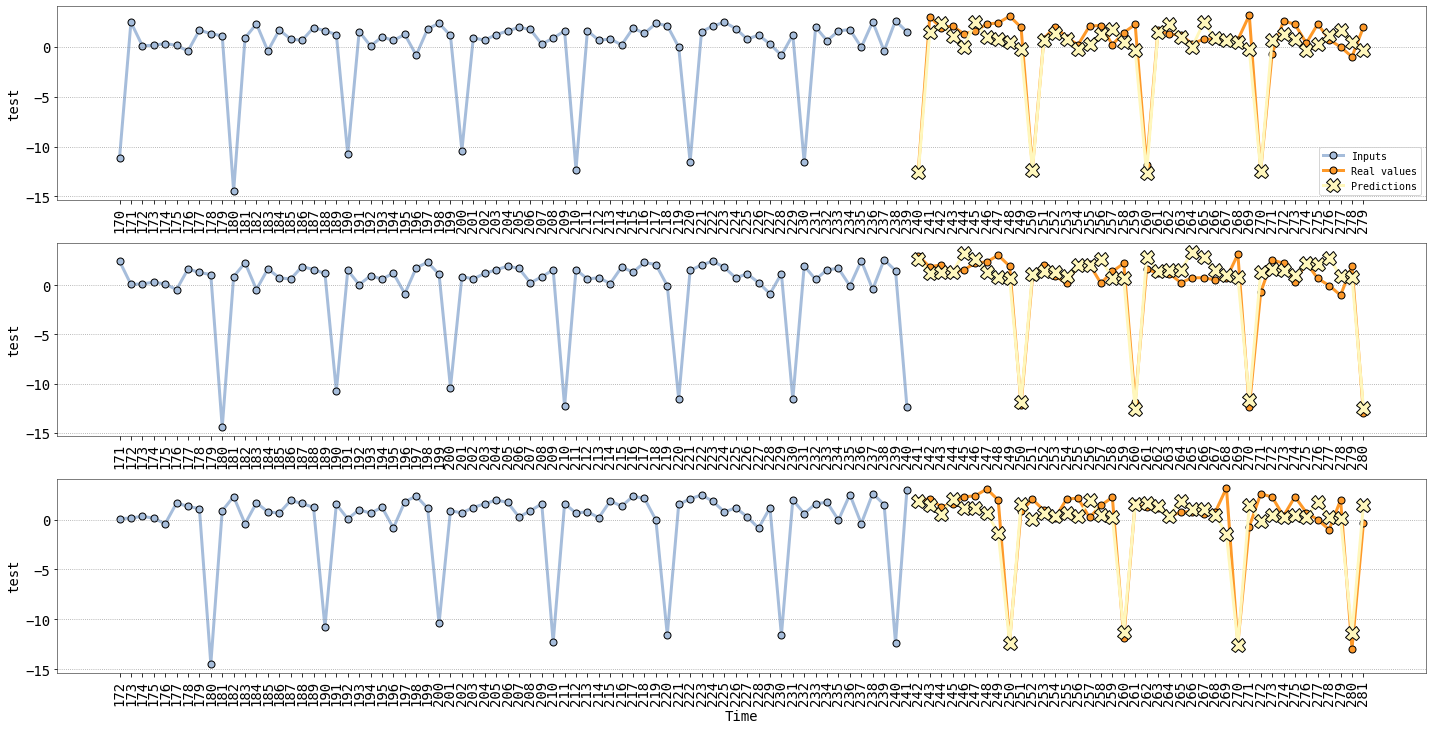

In [37]:
plotter = ShowTs(w, 'test', model)

plotter.plot_from_index('240', 'test')

# Production

In [ ]:
prod = w.production(data)
plt.plot(model1.predict(prod)[0])

# A pool is better than a single model

In [ ]:
from autopycoin.autopycoin.models import PoolNBEATS
from autopycoin.autopycoin.losses import QuantileLossError, SymetricMeanAbsolutePercentageError
import tensorflow_probability as tfp


data = random_ts(n_steps=300, # Number of steps (second dimension)
                 trend_degree=2,
                 periods=[10], # We can combine multiple periods, period is the time length for a cyclical function to reproduce a similar output
                 fourier_orders=[10], # higher is this number, more complex is the output
                 trend_mean=0,
                 trend_std=1,
                 seasonality_mean=0,
                 seasonality_std=1, 
                 batch_size=1, # Generate a batch of data (first dimension)
                 n_variables=1, # Number of variables (last dimension)
                 noise=True, # add normal centered noise
                 seed=42)


w = WindowGenerator(
        input_width=70,
        label_width=10,
        shift=10,
        test_size=50,
        valid_size=10,
        flat=True,
        batch_size=32,
    )

w = w.from_array(data=data[0], # Has to be 2D array
        input_columns=[0],
        known_columns=[],
        label_columns=[0],
        date_columns=[],)

# Or using dataframe
import pandas as pd

data = pd.DataFrame(data[0], columns=['test'])

w = w.from_dataframe(data=data, # Has to be 2D array
        input_columns=['test'],
        known_columns=[],
        label_columns=['test'],
        date_columns=[],)

def median(x, axis):
    return tfp.stats.percentile(x, 50.0, interpolation='midpoint', axis=axis)

model2 = lambda : nbeats.create_generic_nbeats(
            label_width=10,
            g_forecast_neurons=16, 
            g_backcast_neurons=16, 
            n_neurons=16, 
            n_blocks=3,
            n_stacks=2,
            drop_rate=0.,
            share=True)

model = PoolNBEATS(n_models=18, nbeats_models=model2, losses=['mse', 'mape'],
            fn_agg=tf.reduce_mean)


model.compile(tf.keras.optimizers.Adam(
    learning_rate=0.02, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True,
    name='Adam'), loss=model.get_pool_losses(), metrics=['mae'])
model.fit(w.train, validation_data=w.valid, epochs=40)

Epoch 1/40
5/5 [==============================] - 6s 204ms/step - loss: 3537.8210 - output_1_loss: 18.3578 - output_2_loss: 3487.1377 - output_3_loss: 32.3254 - output_1_mae: 2.8965 - output_2_mae: 3.7901 - output_3_mae: 3.7773 - val_output_3_mae: 0.0000e+00
Epoch 2/40
5/5 [==============================] - 0s 56ms/step - loss: 4172.4424 - output_1_loss: 8.0322 - output_2_loss: 4153.1631 - output_3_loss: 11.2467 - output_1_mae: 2.1494 - output_2_mae: 2.9874 - output_3_mae: 2.3326 - val_output_3_mae: 0.0000e+00
Epoch 3/40
5/5 [==============================] - 0s 60ms/step - loss: 2631.4546 - output_1_loss: 4.1566 - output_2_loss: 2619.9807 - output_3_loss: 7.3173 - output_1_mae: 1.5577 - output_2_mae: 2.6730 - output_3_mae: 2.0407 - val_output_3_mae: 0.0000e+00
Epoch 4/40
5/5 [==============================] - 0s 60ms/step - loss: 1739.6556 - output_1_loss: 2.4940 - output_2_loss: 1732.5270 - output_3_loss: 4.6346 - output_1_mae: 1.2329 - output_2_mae: 2.5542 - output_3_mae: 1.6897 - v

In [ ]:
%load_ext tensorboard

from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

import tensorboard
tensorboard.__version__

# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

model.fit(w.train, validation_data=w.valid, epochs=40, callbacks=[tensorboard_callback])

In [ ]:
plotter = ShowTs(w, 'test', model)

plotter.plot_from_index('270', 'test')

NameError: name 'ShowTs' is not defined

In [ ]:
model.evaluate(w.test)

In [ ]:
tf.expand_dims(tf.constant([[[0, 0],[0, 0],[0, 0]]]), axis=1)

In [33]:
tf.transpose(tf.expand_dims(tf.constant([[[0, 0],[1, 0],[2, 0]]]), axis=1), (3, 0, 1, 2))

<tf.Tensor: shape=(2, 1, 1, 3), dtype=int32, numpy=
array([[[[0, 1, 2]]],


       [[[0, 0, 0]]]])>